In [691]:
import pyautogui
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF

In [692]:
import pytesseract
#configure tesseract to use (English language, LSTM neural network, and single-line of text)
config = ("-l eng --oem 1 --psm 7")    # $ tesseract --help-oem 

In [693]:
# pyautogui.mouseInfo()

In [694]:
def iamnothuman():
    #click i am human
    #CLICK_BOX_POSITION = (453,410)
    pyautogui.click(453,410)

In [695]:
#take screenshot
time.sleep(10)
iamnothuman()
time.sleep(10)
im = pyautogui.screenshot()

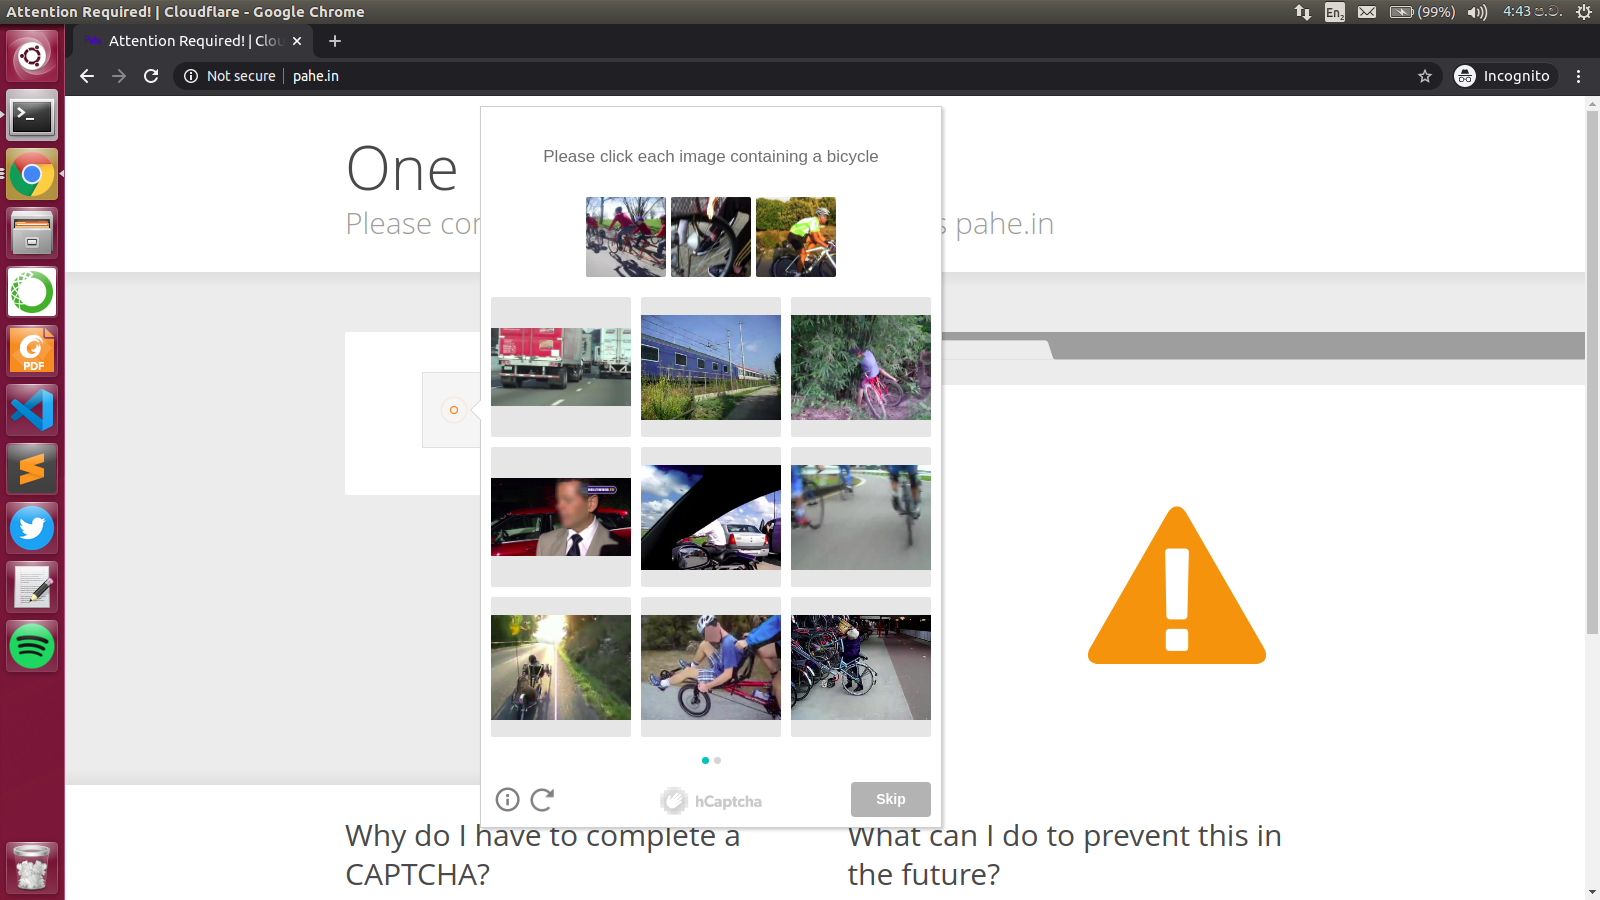

In [696]:
im

In [697]:
# OCR_POSITION = (822,150,916,168)
# #extracting region of interest(ROI)
# roi = im.crop((822,150,916,168))
# roi

In [698]:
# #extracting images category
# category = pytesseract.image_to_string(roi, config=config)

In [699]:
# category

In [700]:
def get_category(img):
    '''
    param : img:screenshot of pahe.in
    return: the category to choose images from
    '''
    OCR_POSITION = (822,150,916,168)
    #extracting region of interest(ROI)
    roi = im.crop(OCR_POSITION)
    #extracting category
    category = pytesseract.image_to_string(roi, config=config)
    
    return category

In [701]:
def get_coordinates(initial = (493,299,631,437)):
    '''return a list of image coordinates in numpy array
    '''
    pic_coors1 = [np.array(initial)]
    pic_coors2 = []
    for i in range(1,3):
        new_pic = np.array(initial) + np.array((150,0,150,0))*i
        pic_coors1.append(new_pic)
        
    for img in pic_coors1:
        for i in range(1,3):
            new_pic = img + np.array((0,150,0,150))*i
            pic_coors2.append(new_pic)
    
    return pic_coors1 + pic_coors2

In [702]:
# coors = get_coordinates()

In [703]:
# plt.imshow(np.asarray(im.crop(chira[0])))

In [704]:
def extract_photos(img):
    '''
    param: img:screenshot image
    return : list of PIL IMAGE objects of 9 images
    '''
    pic_coors = get_coordinates()
    pics = [img.crop(coor) for coor in pic_coors]
    return pics

In [705]:
pil_imgs = extract_photos(im)

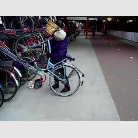

In [706]:
pil_imgs[8]

In [707]:
def preprocess_imgs(img_list):
    '''
    param: img_list: PIL IMAGE list from extract_photos
    
    1.resize images to (224,224) to pass into pretrained models
    2.scale data into (0,1) range
    3.convert to float tensors to pass into model (also note that tensors should be (channels,height,width) we will have to transpose images)
    4.normalize images with 
                            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
                                                             
    return : list with processed float tensors images                                                                
    '''
    processed_tensors = []
    for img in img_list:
        img = TF.resize(img,(224,224))
        img = TF.to_tensor(img)
        img = TF.normalize(img,
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
        processed_tensors.append(img)
        
    return processed_tensors

In [708]:
img_tensors = preprocess_imgs(pil_imgs)

In [709]:
torch.save(img_tensors,'imgs.pt')

In [710]:
torch.save(pil_imgs,'PIL_imgs.pt')

In [711]:
# def get_reference(img):
#     INITIAL_COOR = (588,198,668,278)
#     pics = [img.crop(np.asarray(INITIAL_COOR) + np.asarray((83,0,83,0))*i)  for i in range(3)]
#     return pics

In [712]:
from torchvision import models

In [713]:
# #loading pretrained VGG16 model
# vgg16 = models.vgg16(pretrained=True)
# #set to evaluation mode as we are inferencing
# vgg16.eval()

In [714]:
#loading saved imagenet index to classes dictionary
imagenet_idx2cls = torch.load('imagenet_idx2cls.pt')

In [715]:
#create a dictionary to map ocr to class labels in imagenet 
ocr_dict = {'airplane':['airliner', 'warplane, military plane', 'wing'],
            'a bus':['passenger car, coach, carriage', 'minibus', 'school bus', 'moving van','trolleybus, trolley coach, trackless trolley'],
            'umbrella':['umbrella', "academic gown, academic robe, judge's robe"],
            'umbrella:':['umbrella', "academic gown, academic robe, judge's robe"],
            'bicycle':['mountain bike, all-terrain bike, off-roader', 'bicycle-built-for-two, tandem bicycle, tandem','tricycle, trike, velocipede','mountain bike, all-terrain bike, off-roader','unicycle, monocycle']}

In [716]:
category = get_category(im)
coors = get_coordinates()

for e in range(1):
    for i in range(9): #iterate over each image
        scores = vgg16(img_tensors[i].unsqueeze(0))
        _, top_preds = torch.topk(scores,5,1)
        top_preds = [imagenet_idx2cls[pred.item()] for pred in top_preds[0]]

        for label in ocr_dict[category]:
            if label in top_preds:
                imge_coors = coors[i]
                x,y = (imge_coors[0] + imge_coors[2])/2, (imge_coors[1] + imge_coors[3])/2
                pyautogui.click(x,y,button='left')

                break
#     if e==0:
#         pyautogui.click(889,797)
#         time.sleep(2)
#         im2 = pyautogui.screenshot()
#         pil_imgs2 = extract_photos(im2)
#         img_tensors = preprocess_imgs(pil_imgs2)


In [717]:
pyautogui.click(889,797)
time.sleep(2)
im2 = pyautogui.screenshot()
pil_imgs2 = extract_photos(im2)
img_tensors = preprocess_imgs(pil_imgs2)

In [718]:
for e in range(1):
    for i in range(9): #iterate over each image
        scores = vgg16(img_tensors[i].unsqueeze(0))
        _, top_preds = torch.topk(scores,5,1)
        top_preds = [imagenet_idx2cls[pred.item()] for pred in top_preds[0]]

        for label in ocr_dict[category]:
            if label in top_preds:
                imge_coors = coors[i]
                x,y = (imge_coors[0] + imge_coors[2])/2, (imge_coors[1] + imge_coors[3])/2
                pyautogui.click(x,y,button='left')

                break